# 导入包

In [1]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

## 函数定义

In [2]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

# Source-Extractor处理和结果

## 文件路径和信息

In [3]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C1"
band_index = 1
band_short = "g"
band_short_capital = "G"
day = "230614"
obs_index = "07"
unkonw_index = "01"
exp_time = 600

obs_info = {"01": "20230614054340_20230614054840", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/{day}/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L0_VER.fits'


In [4]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 260.0445206737792, -0.01074148799459571


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [5]:
# 读取已有结果文件
fp_out_sext = f"/home/fangwf/code/csst_mci_multiband_0614/sext_out/{band}_{band_short}_{exp_time}_out.fits"
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out_filter = Table(hdu_list[2].data)

sext_out_filter

Filename: /home/fangwf/code/csst_mci_multiband_0614/sext_out/C1_g_600_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [12000A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   1024R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1E]   


X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,BACKGROUND
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32
3752.0503,688.276,3753.010580922297,688.6257257410157,3578,3883,903,493,260.05640192313297,-0.06528624780417891,260.0563885845342,-0.06528139059682898,260.05640192313297,-0.06528624780417891,119.03847594492605,111.9673410501498,2.7584126646787596e-06,2.5460421109798294e-06,10.91652,10.575226,0.0016611408,0.0015953264,7.7075877,3.869621,0.008401244,0.008931813,0.0335235,0.00015161825,0.00014687801,2.3071388e-08,2.215729e-08,107852860.0,8431.319,-20.082079,8.489726e-05,65773,84.56884,4,607.6098
5811.4175,14.418896,5811.217810195996,14.445314929871657,5810,5813,16,13,260.02779959503744,-0.07464536254541859,260.0278023675447,-0.07464499561187975,260.02779959503744,-0.07464536254541859,0.484504673828277,0.37304676426646177,0.008771380527345171,0.00871407176239574,0.7045791,0.60093236,0.09522164,0.09175125,17.271048,42.46649,2.0809064,2.702634,0.10591674,9.785815e-06,8.346271e-06,1.3225217e-06,1.2743213e-06,365.7975,38.374348,-6.4081016,0.11392791,15,2.697316,0,518.1666
4146.204,7.949215,4146.23531212654,8.014009564335069,4143,4149,11,5,260.0509275644425,-0.07473522181803363,260.05092712920475,-0.07473432189673808,260.0509275644425,-0.07473522181803363,1.145906427595596,0.9122262285864182,0.010241207108811917,0.009666773872981088,1.0856391,0.9378274,0.10132562,0.09818909,19.310194,11.686472,0.88000613,1.1054326,0.07414228,1.5078311e-05,1.3025366e-05,1.4072994e-06,1.3637358e-06,1173.4641,88.82834,-7.6736746,0.08220752,39,1.9211075,16,515.3409
5314.4966,1.5109382,5314.206736857241,1.4983558651897733,5314,5315,2,1,260.0347012743721,-0.07482464158750156,260.0347053002993,-0.07482481634317721,260.0347012743721,-0.07482464158750156,0.6252196729157878,0.41291766281483583,0.02864299671061552,0.02264971962968785,0.79072165,0.6425703,0.16925086,0.15048875,-0.57064116,-1.2501827,1.5994655,2.4218323,0.0011205077,1.0982238e-05,8.924576e-06,2.3507048e-06,2.0901189e-06,231.97174,32.813805,-5.9135876,0.15362126,4,2.9181128,24,515.40375
3499.863,20.76603,3499.693515149135,20.961212977207857,3498,3502,22,19,260.05990452350545,-0.0745572085041763,260.0599068780708,-0.07455449762977598,260.05990452350545,-0.0745572085041763,3.7591148115673474,2.7381902611220985,0.13321083227150832,0.13098076032223935,1.939769,1.6536629,0.36506748,0.361825,-3.387245,-9.442212,0.26611513,0.36533523,0.24016601,2.6941218e-05,2.2967512e-05,5.0703784e-06,5.0253407e-06,595.74316,68.82941,-6.937648,0.12547141,13,2.1951582,0,515.5212
6893.683,41.22306,6893.666423977501,41.19222961010366,6892,6895,43,40,260.0127681251167,-0.0742730747165499,260.01276835842697,-0.07427350291750046,260.0127681251167,-0.0742730747165499,0.8670740670499727,0.5803788782173399,0.026401139442285265,0.02460429336123582,0.93231463,0.7604225,0.16290076,0.15642498,4.9156594,14.832774,1.15472,1.7251278,0.12396759,1.2948803e-05,1.0561409e-05,2.2625088e-06,2.172566e-06,398.1255,54.25026,-6.50005,0.14798294,12,2.3544917,0,515.337
3544.765,275.11066,3544.572378858386,275.08938131181463,3502,3585,318,232,260.0592808854519,-0.07102464851804441,260.05928356025083,-0.07102494420728522,260.0592808854519,-0.07102464851804441,1.4211750406025918,1.1619268840446293,3.2610215856120284e-06,2.771292089743753e-06,1.1931732,1.0767728,0.0018080741,0.0016622822,5.5678225,7.2736

# Gaia参考星获取

## 读取已有或直接网络下载

In [6]:
fp_ref = "/home/fangwf/code/csst_mci_multiband_0614/sext_out/star_cat_230614.fits"
ref_filter = Table(fits.open(fp_ref)[1].data)
ref_filter

ra,dec,magu,magg,magr,magi,magz,Pos_X,Pos_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64
259.98066860907585,0.0020924156379107653,19.606356,18.438757,18.037342,17.879478,17.797276,5539.5411705470015,9204.850674135349
260.04590749648196,0.004902694786529289,24.259224,21.222286,19.781658,18.728922,18.193325,5741.881188335805,4507.64876202479
260.09131614035294,-0.017718360578639993,19.031492,17.223488,16.458712,16.13401,15.951971,4113.164745976878,1238.2257936537767
260.00392589431243,0.031478372371075904,25.204172,22.166964,20.739403,19.447483,18.817167,7655.331065389298,7530.324963095564
260.07819061353075,-0.004813185742807044,29.811892,26.584747,25.08854,23.380672,22.576529,5042.337703814324,2183.2640544088326
260.0493263415502,-0.03057101663500945,26.012894,23.000996,21.576881,20.072891,19.352789,3187.773873144113,4261.491948204683
260.02016599172384,-0.0476501744887235,23.169798,20.964092,20.027906,19.633558,19.409452,1958.0738948963917,6361.036971013289
259.9908270104334,0.0156854641074244,23.051937,23.11605,23.269812,23.515541,23.67426,6518.241182182819,8473.4451589569
260.0346195923188,-0.029217255364075427,26.595865,26.617569,26.731667,26.952118,27.089188,3285.244671880198,5320.377816621687


# 三角形匹配

## Gaia参考星匹配库

In [7]:
refcat_ra_now = np.array(ref_filter["ra"])
refcat_dec_now = np.array(ref_filter["dec"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,260.076563,260.091316,259.980669,0.006354,-0.017718,0.002092,0.112407,0.095989,0.028234
1,260.073040,260.091316,259.980669,-0.047357,-0.017718,0.002092,0.112407,0.104774,0.034821
2,259.996086,259.980669,260.091316,-0.020731,0.002092,-0.017718,0.112407,0.095278,0.027542
3,260.056409,260.091316,259.980669,-0.065295,-0.017718,0.002092,0.112407,0.101379,0.059009
4,260.091316,260.091504,259.980669,-0.017718,0.034595,0.002092,0.115503,0.112407,0.052313
...,...,...,...,...,...,...,...,...,...
134039,260.089752,260.091311,260.019174,-0.053531,-0.055371,-0.012108,0.084116,0.081836,0.002411
134040,260.076483,260.089752,260.010741,-0.023805,-0.053531,0.000459,0.095695,0.070077,0.032553
134041,260.076483,260.091311,260.010741,-0.023805,-0.055371,0.000459,0.098022,0.070077,0.034875
134042,260.089752,260.091311,260.076483,-0.053531,-0.055371,-0.023805,0.034875,0.032553,0.002411


## 图像星匹配库

In [8]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,260.091491,260.040789,260.056389,0.034610,0.044677,-0.065281,0.111060,0.105879,0.051691,2.0,1.0,0.0,2.0,1.0,0.0
1,260.056389,260.100895,260.040789,-0.065281,-0.058419,0.044677,0.119338,0.111060,0.045033,0.0,3.0,1.0,0.0,3.0,1.0
2,260.056389,260.059284,260.040789,-0.065281,-0.071025,0.044677,0.117171,0.111060,0.006432,0.0,4.0,1.0,0.0,4.0,1.0
3,260.079895,260.056389,260.040789,-0.016824,-0.065281,0.044677,0.111060,0.072881,0.053858,5.0,0.0,1.0,5.0,0.0,1.0
4,260.039031,260.056389,260.040789,-0.022378,-0.065281,0.044677,0.111060,0.067078,0.046282,6.0,0.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,260.010728,259.987614,260.071568,0.000470,0.053265,-0.043126,0.127826,0.074848,0.057632,38.0,39.0,35.0,38.0,39.0,35.0
9876,260.054494,260.083023,260.010728,-0.051796,-0.005709,0.000470,0.072559,0.068171,0.054203,37.0,36.0,38.0,37.0,36.0,38.0
9877,260.083023,260.054494,259.987614,-0.005709,-0.051796,0.053265,0.124542,0.112164,0.054203,36.0,37.0,39.0,36.0,37.0,39.0
9878,260.010728,259.987614,260.083023,0.000470,0.053265,-0.005709,0.112164,0.072559,0.057632,38.0,39.0,36.0,38.0,39.0,36.0


## 三角形弧长匹配

In [9]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,260.091491,260.040789,260.056389,0.034610,0.044677,-0.065281,2.0,1.0,0.0,2.0,1.0,0.0,260.091504,260.040804,260.056409,0.034595,0.044662,-0.065295
1,260.056389,260.100895,260.040789,-0.065281,-0.058419,0.044677,0.0,3.0,1.0,0.0,3.0,1.0,260.056409,260.100910,260.040804,-0.065295,-0.058434,0.044662
2,260.056389,260.059284,260.040789,-0.065281,-0.071025,0.044677,0.0,4.0,1.0,0.0,4.0,1.0,260.056409,260.059297,260.040804,-0.065295,-0.071040,0.044662
3,260.079895,260.056389,260.040789,-0.016824,-0.065281,0.044677,5.0,0.0,1.0,5.0,0.0,1.0,260.079910,260.056409,260.040804,-0.016838,-0.065295,0.044662
4,260.039031,260.056389,260.040789,-0.022378,-0.065281,0.044677,6.0,0.0,1.0,6.0,0.0,1.0,260.039045,260.056409,260.040804,-0.022391,-0.065295,0.044662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9256,260.010728,259.987614,260.071568,0.000470,0.053265,-0.043126,38.0,39.0,35.0,38.0,39.0,35.0,260.010741,259.987628,260.071580,0.000459,0.053253,-0.043140
9257,260.054494,260.083023,260.010728,-0.051796,-0.005709,0.000470,37.0,36.0,38.0,37.0,36.0,38.0,260.054506,260.083037,260.010741,-0.051809,-0.005722,0.000459
9258,260.083023,260.054494,259.987614,-0.005709,-0.051796,0.053265,36.0,37.0,39.0,36.0,37.0,39.0,260.083037,260.054506,259.987628,-0.005722,-0.051809,0.053253
9259,260.010728,259.987614,260.083023,0.000470,0.053265,-0.005709,38.0,39.0,36.0,38.0,39.0,36.0,260.010741,259.987628,260.083037,0.000459,0.053253,-0.005722


## 结果

In [23]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [24]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

[[ 2.35594401e-07 -2.42410491e-07  2.41498415e-12]
 [-2.24521512e-07  1.69900002e-12  2.42409362e-07]]


### 应用初步底片模型

In [25]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[  5.14363387  -2.06601758 -27.9496579   -3.06881489  -1.67655048
  -5.36531884  -4.95320116  -1.08441138 -11.40985853   1.0148203
   0.26113005   3.53794485   2.89957329  -0.2322397    0.26574562
   5.44137356   1.963063     4.50823384  -0.1291734    0.66908726
   3.17531396   0.74739053   1.95637058   1.23297509   6.63944179
  -1.60422076   1.46518062   6.76590068   0.67978094   0.68405907
  -0.51018246   1.56949213   5.31404312  -1.45256602   3.35392238
   1.42505      4.00680367  -1.87150954  -1.34661761]
[ 7.82070809  9.65759002  1.6931345   8.00125825  4.11276753  4.57437002
  1.47873818  2.595946    5.86071546 -2.07621387 -3.33197479  0.93920106
 -1.9788026  -1.02641984 -2.34772081 -1.83046226 -1.02198959  0.02123079
 -2.02747908 -1.64494984 -1.99797843 -1.62204066 -1.41565355 -0.83786574
 -2.85763072 -0.78250161  0.10641408 -2.47910994 -0.85202241 -3.89001324
 -2.5296381  -1.18284591  0.4215939  -3.44362718  0.43866771 -2.10661058
 -1.81997798 -2.47198961 -0.14685083]


### 画图

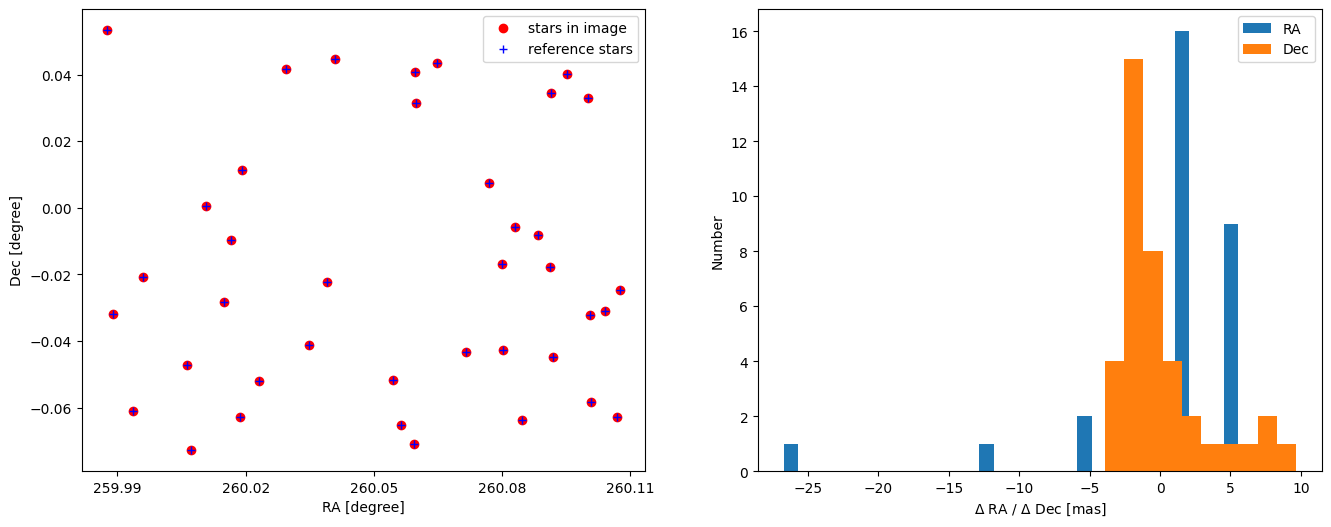

In [26]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

## 更新底片模型

### 全体星应用初步模型

In [27]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [28]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [29]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
cof_mag = 3

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 985
[[ 4.99159008e-07 -2.42407961e-07  1.65379727e-12 -4.18689844e-09
  -9.98124633e-10  2.97853624e-11]
 [ 2.75509099e-06  1.08636636e-12  2.42409612e-07 -4.25564870e-07
   1.99092331e-08 -3.06415902e-10]]


### 再应用更新的底片模型

In [30]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

6.304185831933048 6.406798921386725 1 3


In [31]:
# 保存
cof_mag_orders = 4
cof_xy = 1
for cof_mag in np.arange(1, cof_mag_orders + 1):

    A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

    match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
    match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
    gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
    gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

    # 残差
    dis_xi = (match_xieta[0] - gaia_xieta[0])
    dis_eta = (match_xieta[1] - gaia_xieta[1])
    dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
    dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

    match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

    with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
        pickle.dump(match_res_pickle, f)

# 残差分析

## 残差图

### 网格化

In [32]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

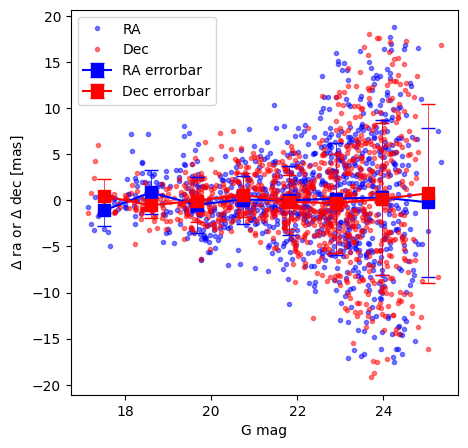

In [33]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, 8)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, 8)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='blue',elinewidth=0.5,marker='s',mfc='blue',mec='blue',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='red',elinewidth=0.5,marker='s',mfc='red',mec='red',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec [mas]")

        axe.legend()

In [34]:
# def bins_divide(data, relative_data, bins_num):

#     bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
#     bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

#     bins_dis = []
#     bins_mean = []
#     bins_id_data = np.digitize(data, bins_interval) - 1

#     for i in range(0, bins_num):
#         index_divide = bins_id_data == i
#         bins_dis.append(np.std(relative_data[index_divide]))
#         bins_mean.append(np.mean(relative_data[index_divide]))

#     return bins_center_interval, bins_mean, bins_dis

# bin_centers_mag_box, bins_mean_box,bins_dis_box = bins_divide(match_mag_box, dis_ra_box, 8)

# plt.errorbar(bin_centers_mag_box, bins_mean_box,yerr=bins_dis_box,ecolor='k',elinewidth=0.5,marker='s',mfc='orange',mec='k',mew=1,ms=10,alpha=1,capsize=5,capthick=3,color="orange",label="Observation")

### 位置残差图

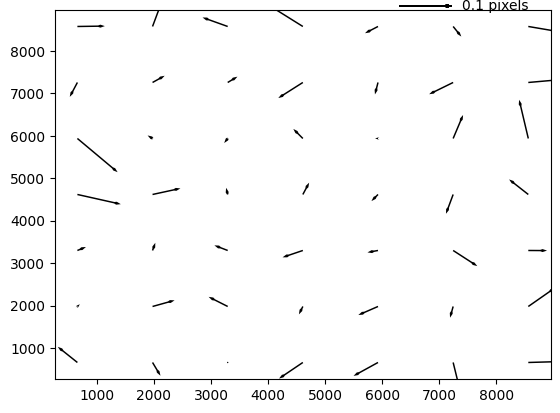

In [42]:
bins_num = 7
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')

In [40]:
len(match_x[filter][index_mag])

953

In [43]:
distort_sum_bins

array([[22., 21., 25., 18., 13., 17., 19.],
       [23., 27., 23., 25., 25., 17., 20.],
       [18., 20., 21., 27., 29., 18., 17.],
       [22., 19., 18., 21., 19., 14., 13.],
       [13., 21., 20., 10., 21., 23., 17.],
       [22., 23., 19., 17., 22., 16., 19.],
       [10., 17., 13., 17., 30., 13., 19.]])